###Reading the Dataset

In [0]:
%pip install gdown

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%sh
gdown 1fH1V1SLB-GXsktREDo7JIkndV0DHKC73
ls -l

Downloading...
From: https://drive.google.com/uc?id=1fH1V1SLB-GXsktREDo7JIkndV0DHKC73
To: /databricks/driver/data.csv

  0%|          | 0.00/10.0M [00:00<?, ?B/s]
 47%|████▋     | 4.72M/10.0M [00:00<00:00, 43.4MB/s]
100%|██████████| 10.0M/10.0M [00:00<00:00, 70.2MB/s]
total 11080
drwxr-xr-x 2 root root     4096 Jan  1  1970 azure
drwxr-xr-x 2 root root     4096 Jan  1  1970 conf
-rw-r--r-- 1 root root 10008604 Jan 13 00:55 data.csv
drwxr-xr-x 3 root root     4096 Jan 13 00:51 eventlogs
-r-xr-xr-x 1 root root     3037 Jan  1  1970 hadoop_accessed_config.lst
drwxr-xr-x 2 root root     4096 Jan 13 00:55 logs
drwxr-xr-x 5 root root     4096 Jan 13 00:54 metastore_db
-r-xr-xr-x 1 root root  1306848 Jan  1  1970 preload_class.lst


In [0]:
# If running on DataBricks, Please Install Spark NLP by going to 
#Cluster>Libraries>Install New>PyPI>spark-nlp==4.2.4
#AND
#Cluster>Libraries>Maven>Search Packages>Maven Central>com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.4

In [0]:
import sparknlp
spark = sparknlp.start() 
# sparknlp.start(gpu=True) >> for training on GPU
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
from pyspark.ml import Model
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, StringIndexer, VectorAssembler, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.sql.functions import col
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import re

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)


Spark NLP version 4.2.4
Apache Spark version: 3.3.1


In [0]:
data = spark.read.csv('file:/databricks/driver/data.csv', inferSchema=True, header=True, mode='DROPMALFORMED')
data.show(1)

+-----+--------------+-------+--------------------+
|index|         title|  genre|             summary|
+-----+--------------+-------+--------------------+
|    4|Taran Wanderer|fantasy| Taran and Gurgi ...|
+-----+--------------+-------+--------------------+
only showing top 1 row



### Exploratory Data Analysis

In [0]:
data.groupBy("genre") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------------------+-----+
|               genre|count|
+--------------------+-----+
|                null| 1853|
|            thriller| 1023|
|             fantasy|  876|
|             science|  646|
|             history|  600|
|              horror|  600|
|               crime|  500|
|             romance|  111|
|              travel|  100|
|          psychology|  100|
|              sports|  100|
|             however|    6|
|              though|    5|
|                 too|    4|
| these ""shining ...|    3|
| the popular new ...|    3|
| and their awe-in...|    3|
|                 and|    3|
| the brave shinin...|    3|
|           after all|    3|
+--------------------+-----+
only showing top 20 rows



From above cell we can see there are many bla bla categories, so removing all of them.

In [0]:
data = data.filter((data.genre=='thriller') | (data.genre=='fantasy') | (data.genre=='science') | (data.genre=='history') | (data.genre=='horror') | (data.genre=='crime'))
data.groupBy("genre") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|   genre|count|
+--------+-----+
|thriller| 1023|
| fantasy|  876|
| science|  646|
| history|  600|
|  horror|  600|
|   crime|  500|
+--------+-----+



In [0]:
df_countgenre=data.groupBy("genre") \
    .count() \
    .orderBy(col("count").desc())


In [0]:
display(df_countgenre)

genre,count
thriller,1023
fantasy,876
science,646
history,600
horror,600
crime,500


Output can only be rendered in Databricks

Output can only be rendered in Databricks

### Data Preprocessing

In [0]:
# Clean description using regular-expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="summary", outputCol="words", pattern="\\W")

# exclue stop words
add_stopwords = ["a","an","the","of","at"] 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag-of-words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

# StringIndexer
label_stringIdx = StringIndexer(inputCol = "genre", outputCol = "label")

In [0]:
# Put everything in pipeline (We use regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx)
# you can use hasingTF and IDF alternatively than countVectors
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+-----+--------------------+-------+--------------------+--------------------+--------------------+--------------------+-----+
|index|               title|  genre|             summary|               words|            filtered|            features|label|
+-----+--------------------+-------+--------------------+--------------------+--------------------+--------------------+-----+
|    4|      Taran Wanderer|fantasy| Taran and Gurgi ...|[taran, and, gurg...|[taran, and, gurg...|(7429,[0,1,2,3,4,...|  1.0|
|    5|      Thendara House|fantasy| The novel concer...|[the, novel, conc...|[novel, concerns,...|(7429,[0,2,11,14,...|  1.0|
|    6|           The Thief|fantasy| Gen is released ...|[gen, is, release...|[gen, is, release...|(7429,[0,1,2,3,5,...|  1.0|
|    7| The Sweet Far Thing|fantasy| The prologue beg...|[the, prologue, b...|[prologue, begins...|(7429,[0,1,2,3,4,...|  1.0|
|    8|Mistborn: The Fin...|fantasy| In Luthadel, the...|[in, luthadel, th...|[in, luthadel, ca...|(7429,[0,1,2

In [0]:
# Split Train/Test data
(trainingData, testData) = dataset.randomSplit([0.75, 0.25], seed = 623)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 2139
Test Dataset Count: 742


### Data Modelling And Evaluation

#### Logistic Regression Modelling

In [0]:
# We use Logistic-Regression model
lr = LogisticRegression()
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("summary","genre","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                       summary|   genre|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|She was born with her eyes ...| fantasy|[1.0,9.324662508550686E-17,...|  1.0|       0.0|
|Could ten days at a health ...|thriller|[1.0,8.021600098141272E-17,...|  0.0|       0.0|
| The city of Phlan has vani...| fantasy|[1.0,3.463789813396197E-22,...|  1.0|       0.0|
|Under the streets of London...| fantasy|[1.0,5.1228290287648526E-23...|  1.0|       0.0|
|Manchmal ist es ein echtes ...| fantasy|[1.0,4.136199160170712E-24,...|  1.0|       0.0|
| A mugger is attacking wome...|   crime|[1.0,1.0937038853217975E-25...|  4.0|       0.0|
| The story begins with Bob ...|thriller|[1.0,3.853424468146316E-27,...|  0.0|       0.0|
|Where were you on October 1...|thriller|[1.0,3.5276972128961294E-30...|  0.0|       0.0|
|At the he

##### Logistic Regression Accuracy

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
LrAccuracy = evaluator.evaluate(predictions)
print("Logistic Regression Accuracy is : ", LrAccuracy) 

Logistic Regression Accuracy is :  0.5754358769394988


#### Decision Tree Classifier Modelling

In [0]:
tree = DecisionTreeClassifier()
tree_model = tree.fit(trainingData)
prediction = tree_model.transform(testData)
prediction.select('label', 'prediction', 'probability').show(n = 5, truncate = 30)


+-----+----------+------------------------------+
|label|prediction|                   probability|
+-----+----------+------------------------------+
|  4.0|       0.0|[0.34296028880866425,0.2151...|
|  4.0|       0.0|[0.34296028880866425,0.2151...|
|  4.0|       0.0|[0.34296028880866425,0.2151...|
|  4.0|       0.0|[0.34296028880866425,0.2151...|
|  4.0|       4.0|[0.24468085106382978,0.0425...|
+-----+----------+------------------------------+
only showing top 5 rows



##### Decision Tree Classifier Accuracy

In [0]:
prediction.groupBy('label', 'prediction').count().show(n = 5, truncate = 30)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
DtAccuracy = evaluator.evaluate(predictions)
print("Accuracy for Decision Tree Classifier is: ",DtAccuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   50|
|  3.0|       5.0|    1|
|  1.0|       1.0|   19|
|  3.0|       2.0|   15|
|  4.0|       2.0|   18|
+-----+----------+-----+
only showing top 5 rows

Accuracy for Decision Tree Classifier is:  0.5754358769394988


#### NaiveBayes Modelling

In [0]:
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("summary","genre","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 5, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                       summary|   genre|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| A plane crashes over the A...|thriller|[1.0,3.43860343721215E-31,4...|  0.0|       0.0|
| Set in the town of Bolton,...|thriller|[1.0,1.8021776540582083E-33...|  0.0|       0.0|
| It is 1944. A message from...|  horror|[1.0,8.269282901963391E-41,...|  5.0|       0.0|
| The book begins with James...|thriller|[1.0,1.2789387407877632E-53...|  0.0|       0.0|
| In January 1954 a United S...|thriller|[1.0,2.075755428626434E-63,...|  0.0|       0.0|
+------------------------------+--------+------------------------------+-----+----------+
only showing top 5 rows



##### NaiveBayes Accuracy

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
NbAccuracy = evaluator.evaluate(predictions)
print("Accuracy for NaiveBayes is: ",NbAccuracy)

Accuracy for NaiveBayes is:  0.6470495521740277


#### Cross Validation

In [0]:
# Pipeline basic to be shared across model fitting and testing
pipeline = Pipeline(stages=[])  # Must initialize with empty list!

# base pipeline (the processing here should be reused across pipelines)
basePipeline =[]

#############################################################
# Specify Logistic Regression model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

pl_lr = basePipeline + [lr]
pg_lr = ParamGridBuilder()\
          .baseOn({pipeline.stages: pl_lr})\
          .addGrid(lr.regParam,[0.1, .4])\
          .build()
#############################################################
# Specify Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="label",featuresCol= "features")
pl_dt = basePipeline + [dt]
pg_dt = ParamGridBuilder()\
      .baseOn({pipeline.stages: pl_dt})\
      .addGrid(dt.maxDepth, [2, 5, 8])\
      .addGrid(dt.maxBins, [10, 15, 20])\
      .build()

#############################################################
# Naive Bayes Tree model
nb = NaiveBayes(smoothing=1)
pl_nb = basePipeline + [nb]
pg_nb = ParamGridBuilder()\
      .baseOn({pipeline.stages: pl_nb})\
      .build()

# One grid from the individual grids
paramGrid = pg_lr + pg_dt + pg_nb


In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

In [0]:
cv = CrossValidator()\
      .setEstimator(pipeline)\
      .setEvaluator(evaluator)\
      .setEstimatorParamMaps(paramGrid)\
      .setNumFolds(2)

cvModel = cv.fit(trainingData)

##### Cross Validation Results

In [0]:
print("Best Model")
print(cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ])
print("Worst Model")
print (cvModel.getEstimatorParamMaps()[ np.argmin(cvModel.avgMetrics) ])

Best Model
{Param(parent='Pipeline_c7abfb3aba67', name='stages', doc='a list of pipeline stages'): [NaiveBayes_ba780edf7644]}
Worst Model
{Param(parent='Pipeline_c7abfb3aba67', name='stages', doc='a list of pipeline stages'): [DecisionTreeClassifier_2cd64c5c6af2], Param(parent='DecisionTreeClassifier_2cd64c5c6af2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2, Param(parent='DecisionTreeClassifier_2cd64c5c6af2', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10}


In [0]:

def paramGrid_model_name(model):
    params = [v for v in model.values() if type(v) is not list]
    name = [v[-1] for v in model.values() if type(v) is list][0]
    name = re.match(r'([a-zA-Z]*)', str(name)).groups()[0]
    return "{}{}".format(name,params)

# Resulting metric and model description
# get the measure from the CrossValidator, cvModel.avgMetrics
# get the model name & params from the paramGrid
# put them together here:
measures = zip(cvModel.avgMetrics, [paramGrid_model_name(m) for m in paramGrid])
metrics,model_names = zip(*measures)

<Figure size 432x288 with 0 Axes>

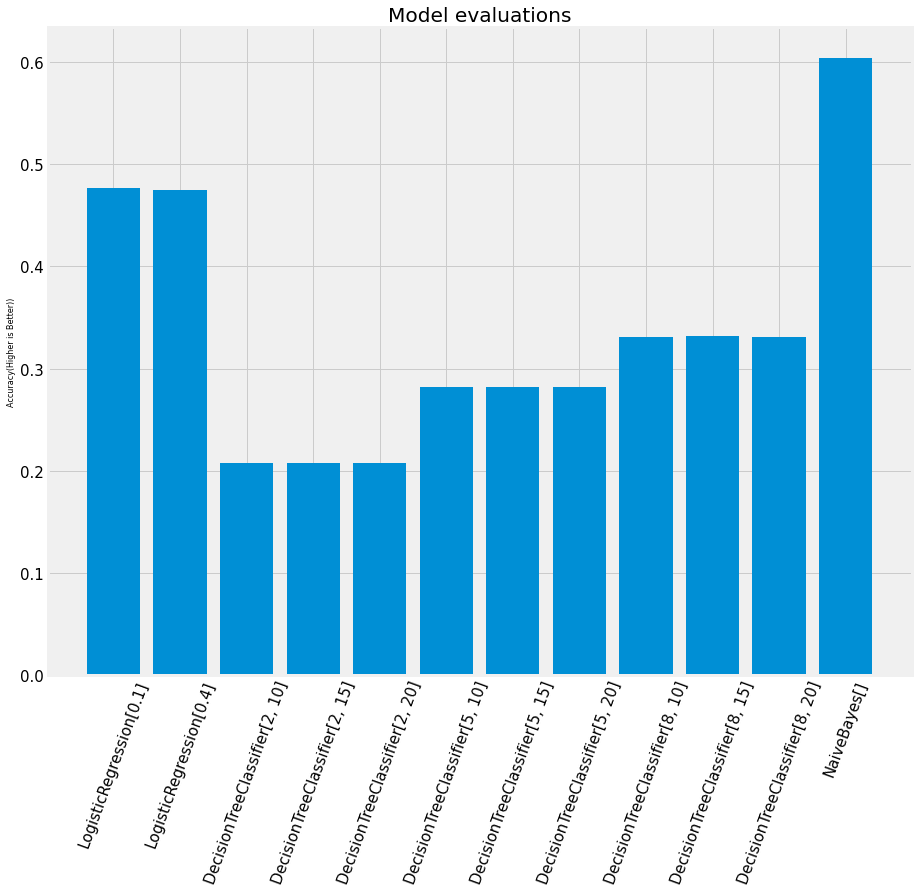

In [0]:
plt.clf() # clear figure
fig = plt.figure( figsize=(15, 15))
plt.style.use('fivethirtyeight')
axis = fig.add_axes([0.1, 0.3, 0.8, 0.6])
# plot the metrics as Y
#plt.plot(range(len(model_names)),metrics)
plt.bar(range(len(model_names)),metrics)
# plot the model name & param as X labels
plt.xticks(range(len(model_names)), model_names, rotation=70, fontsize=15)
plt.yticks(fontsize=15)
#plt.xlabel('model',fontsize=8)
plt.ylabel('Accuracy(Higher is Better))',fontsize=8)
plt.title('Model evaluations')
display(plt.show())

In [0]:
list(metrics)

Out[24]: [0.4763571831320177,
 0.4743362596181957,
 0.20776066652625697,
 0.20776066652625697,
 0.20776066652625697,
 0.28153838519432894,
 0.2822844335327904,
 0.28153838519432894,
 0.3313410069640008,
 0.3321887459914721,
 0.33136496000194127,
 0.6036891684520624]

#### SPARK NLP

##### Universal Sentence Encoder

In [0]:
document = DocumentAssembler()\
    .setInputCol("summary")\
    .setOutputCol("document")
    
# we can also use sentence detector here 
# if we want to train on and get predictions for each sentence
# downloading pretrained embeddings
use = UniversalSentenceEncoder.pretrained()\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")
# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("genre")\
  .setMaxEpochs(10)\
  .setLr(0.001)\
  .setBatchSize(40)\
  .setMaxEpochs(5)\
  .setEnableOutputLogs(True)
use_clf_pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [0]:
use_pipelineModel = use_clf_pipeline.fit(trainingData)

In [0]:
preds = use_pipelineModel.transform(testData)

###### Accuracy

In [0]:
preds_df = preds.select('genre','summary',"class.result").toPandas()
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])
print (classification_report(preds_df['genre'], preds_df['result']))
UniversalAccuracy = accuracy_score(preds_df['genre'],preds_df['result'])
print("Accuracy with Universal Sentence Encoder is: ",UniversalAccuracy)

              precision    recall  f1-score   support

       crime       0.00      0.00      0.00        88
     fantasy       0.48      0.84      0.61       161
     history       0.00      0.00      0.00       106
      horror       0.00      0.00      0.00        87
     science       0.67      0.67      0.67        96
    thriller       0.47      0.85      0.61       204

    accuracy                           0.50       742
   macro avg       0.27      0.39      0.31       742
weighted avg       0.32      0.50      0.39       742

Accuracy with Universal Sentence Encoder is:  0.5013477088948787
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classific

In [0]:
preds_df.head()

,genre,summary,result
0,crime,"The novel's central character is Joe Cashin, ...",thriller
1,crime,"While staying with his Aunt Jane in Suffolk, ...",thriller
2,crime,The book's plot concerns the murder of Ulysse...,thriller
3,crime,The story begins with Tetsuya Ishigami and Ya...,fantasy
4,crime,When the esteemed flautist Sir Manuel Camargu...,thriller


##### Bert embedding

In [0]:
document_assembler = DocumentAssembler() \
                .setInputCol("summary") \
                .setOutputCol("document")

tokenizer = Tokenizer() \
                .setInputCols(["document"]) \
                .setOutputCol("token")
      
bert_embeddings = BertEmbeddings().pretrained(name='small_bert_L4_256', lang='en') \
                .setInputCols(["document",'token'])\
                .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
                .setInputCols(["document", "embeddings"]) \
                .setOutputCol("sentence_embeddings") \
                .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
                .setInputCols(["sentence_embeddings"])\
                .setOutputCol("class")\
                .setLabelColumn("genre")\
                .setMaxEpochs(40)\
                .setLr(0.001)\
                .setBatchSize(20)\
                .setEnableOutputLogs(True)
                #.setOutputLogsPath('logs')

bert_clf_pipeline = Pipeline(stages=[document_assembler,
                                     tokenizer,
                                     bert_embeddings,
                                     embeddingsSentence,
                                     classsifierdl])

small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]


In [0]:
bert_clf_pipelineModel = bert_clf_pipeline.fit(trainingData)

In [0]:
preds = bert_clf_pipelineModel.transform(testData)

###### Accuracy

In [0]:
preds_df = preds.select('genre','summary',"class.result").toPandas()
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])
print (classification_report(preds_df['genre'], preds_df['result']))
BertAccuracy = accuracy_score(preds_df['genre'],preds_df['result'])
print("Accuracy with Bert Embedding is: ",BertAccuracy)

              precision    recall  f1-score   support

       crime       0.00      0.00      0.00        88
     fantasy       0.52      0.75      0.61       161
     history       0.62      0.47      0.54       106
      horror       0.00      0.00      0.00        87
     science       0.62      0.47      0.54        96
    thriller       0.45      0.79      0.57       204

    accuracy                           0.51       742
   macro avg       0.37      0.41      0.38       742
weighted avg       0.41      0.51      0.44       742

Accuracy with Bert Embedding is:  0.5080862533692723
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:131

### Summary And Evaluation

In [0]:
###Creating a comparision of models 

models = list(model_names) + ["Classifier DL with BERT embedding","Classifier DL with Universal embedding"]
Accuracies = list(metrics) + [BertAccuracy , UniversalAccuracy]
result = pd.DataFrame(list(zip(Accuracies, models)),
               columns =['Accuracies', 'models'])
display(result)

Accuracies,models
0.4763571831320177,LogisticRegression[0.1]
0.4743362596181957,LogisticRegression[0.4]
0.20776066652625697,"DecisionTreeClassifier[2, 10]"
0.20776066652625697,"DecisionTreeClassifier[2, 15]"
0.20776066652625697,"DecisionTreeClassifier[2, 20]"
0.28153838519432894,"DecisionTreeClassifier[5, 10]"
0.2822844335327904,"DecisionTreeClassifier[5, 15]"
0.28153838519432894,"DecisionTreeClassifier[5, 20]"
0.3313410069640008,"DecisionTreeClassifier[8, 10]"
0.3321887459914721,"DecisionTreeClassifier[8, 15]"


Output can only be rendered in Databricks

Performance Evaluation
1. We tried multiple models, such as basic models and spark nlp models
2. We used cross validator to check the performance of all out of which Naive bayes performed the best
3. From Spark NLP we used classifier DL model with Universal and Bert Embeddings.
4. We believe that less data samples could be the major reason for low performance.

Learnings
1. We learned to work with text embeddings. 
2. We also got a chance to work with spark nlp models
3. Our solution dealt with multiclass classification

references
https://github.com/hyunjoonbok/PySpark/blob/master/Multi-class%20Text%20Classification%20Problem%20with%20PySpark%20and%20MLlib.ipynb